# Plant Pathology 2020 - FGVC7

# Data Loading and Cleaning

In [1]:
from fastai.vision import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [192]:
data_root = Path("data")

In [193]:
data = pd.read_csv(data_root/"train.csv")
test = pd.read_csv(data_root/"test.csv")

In [194]:
data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [195]:
healthy, mult, rust, scab = "healthy", "multiple_diseases", "rust", "scab"

In [196]:
items_arr = [healthy, mult, rust, scab]
for item in items_arr:
    data.loc[data[item] == 1, "class"] = item

In [197]:
data.drop(items_arr, axis=1, inplace=True)

# Modeling

In [198]:
train = (ImageList.from_df(data, data_root/"images", suffix=".jpg")
       .split_by_rand_pct(0.2, seed=2)
       .label_from_df("class")
       .transform(get_transforms(), size=224)
       .databunch(bs=32)
       .normalize(imagenet_stats))

In [199]:
test_data = ImageList.from_df(test, data_root/"images", suffix=".jpg")

In [286]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])

## Pre-freezing learning rate experiments

In [56]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


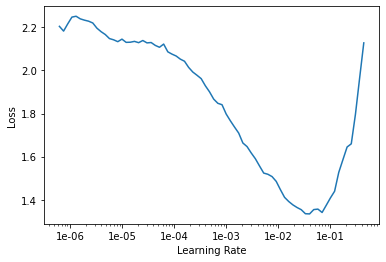

In [57]:
learner.recorder.plot()

In [224]:
lr = 1e-3

In [229]:
lr = 2e-3

In [234]:
lr = 3e-3

In [238]:
lr = 2e-2

In [122]:
lr = 2e-4

In [247]:
lr = 2e-2 / 2

In [287]:
lr = 2e-2
learner.fit_one_cycle(4, lr/2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.003430,1.976647,0.651099,0.348901,00:39
1,0.716265,0.650519,0.791209,0.208791,00:38
2,0.475497,0.303710,0.903846,0.096154,00:39
3,0.349247,0.232928,0.945055,0.054945,00:39


In [288]:
learner.save('resnet152-best3')

In [165]:
lr=2e-2
learner.fit_one_cycle(4, lr/2, moms=(0.8, 0.7), wd=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.906917,1.404710,0.741758,0.258242,00:40
1,0.645778,0.378282,0.879121,0.120879,00:40
2,0.473436,0.286530,0.909341,0.090659,00:41
3,0.314794,0.232664,0.934066,0.065934,00:40


In [167]:
learner.fit_one_cycle(1, lr/2, moms=(0.8, 0.7), wd=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.452670,0.194426,0.961538,0.038462,00:40


In [168]:
learner.save('resnet152-best')

In [284]:
lr=2e-2
learner.fit_one_cycle(6, lr/2, moms=(0.8, 0.7), wd=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.877585,1.988076,0.659341,0.340659,00:38
1,0.747775,0.539531,0.881868,0.118132,00:38
2,0.583910,0.522680,0.890110,0.109890,00:39
3,0.431655,0.442135,0.903846,0.096154,00:39
4,0.322531,0.270734,0.925824,0.074176,00:39
5,0.221242,0.228665,0.936813,0.063187,00:39


In [285]:
learner.save('resnet152-best2')

The results from my experiments are:

- lr = 1e-3 -> error_rate = 0.098 (5 cycles)
- lr = 2e-3 -> error_rate = 0.052 (5 cycles)
- lr = 3e-3 -> error_rate = 0.06 (4 cycles)
- lr = 2e-2 -> error_rate = 0.087 (4 cycles)
- lr = 2e-4 -> error_rate = 0.074 (8 cycles)

Let's add some momentums. `moms=(0.8,0.7)`

- lr = 2e-3 -> error_rate = 0.071 (5 cycles)
- lr = 3e-3 -> error_rate = 0.063 (4 cycles)
- lr = 1e-3 -> error_rate = 0.071 (3 cycles)
- lr = 2e-4 -> error_rate = 0.087 (10 cycles)
- lr = 2e-2 -> error_rate = 0.065 (6 cycles)
- lr = 2e-2/2 -> error_rate = 0.049451 (6 cycles)

Let's try with some weight decay `wd=1e-1`.

- lr = 1e-3 -> error_rate = 0.063187 (5 cycles)
- lr = 2e-3 -> error_rate = 0.074176 (5 cycles)
- lr = 3e-3 -> error_rate = 0.065934 (4 cycles)
- lr = 2e-2 -> error_rate = 0.074176 (4 cycles)
- lr = 2e-2/2 -> error_rate = 0.071429 (4 cycles)

Let's try weights and momentums `wd=1e-3`, `moms=(0.8, 0.7)`.

- lr = 2e-2/2 -> error_rate 0.038462 (6 cycles)
- lr = 1e-3 -> error_rate 0.076923 (3 cycles)
- lr = 2e-3 -> error_rate 0.060440 (4 cycles)
- lr = 3e-3 -> error_rate 0.057692 (4 cycles)
- lr = 2e-2 -> error_rate 0.060440 (4 cycles)

Let's try weights and momentums `wd=1e-2`, `moms=(0.8,0.7)`.

- lr = 2e-2/2 -> error_rate 0.052198 (6 cycles)
- lr = 3e-3 -> error_rate 0.054945 (5 cycles)
- lr = 2e-3 -> error_rate 0.060440 (5 cycles)

In [270]:
best_lr = 2e-2/2
best_mom = (0.8, 0.7)
best_wd = 1e-3

Let's go on to unfreezing the model.

In [350]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])

In [294]:
model = 'resnet152-best'

In [306]:
model = 'resnet152-best2'

In [351]:
model = 'resnet152-best3'

In [352]:
learner.load(model);

In [353]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


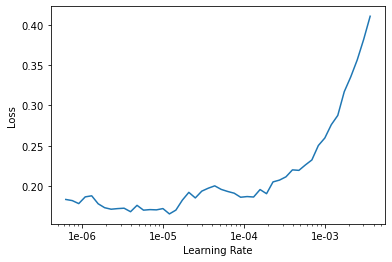

In [318]:
learner.lr_find()
learner.recorder.plot();

In [343]:
end = 2e-6
start = 1e-5

In [338]:
learner.fit_one_cycle(5, max_lr=slice(start, end), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.158214,0.231174,0.931319,0.068681,00:49
1,0.173532,0.204266,0.934066,0.065934,00:49
2,0.166517,0.207318,0.936813,0.063187,00:49
3,0.168916,0.191211,0.953297,0.046703,00:49
4,0.150303,0.192776,0.950549,0.049451,00:49


In [344]:
learner.fit_one_cycle(5, max_lr=slice(start, end), wd=1e-1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.207800,0.224604,0.939560,0.060440,00:49
1,0.195262,0.218307,0.942308,0.057692,00:48
2,0.183774,0.201698,0.953297,0.046703,00:49
3,0.183011,0.189743,0.956044,0.043956,00:49
4,0.168968,0.197432,0.947802,0.052198,00:49


In [355]:
learner.save('resnet152-best-frozen2')

In [309]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])
learner.load('resnet152-best2')
start = 5e-6
end = 2e-5

In [310]:
learner.fit_one_cycle(6, max_lr=slice(start, end), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.164616,0.208171,0.936813,0.063187,00:50
1,0.153331,0.204779,0.936813,0.063187,00:48
2,0.154019,0.196301,0.942308,0.057692,00:49
3,0.121548,0.193325,0.945055,0.054945,00:49
4,0.111435,0.183859,0.950549,0.049451,00:48
5,0.118031,0.185513,0.953297,0.046703,00:49


In [312]:
learner.save('resnet152-best-unfrozen')

## Working with transformations

In [356]:
ds_tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_rotate=90.0,
    max_zoom=1.5,
    max_lighting=0.4,
    max_warp=0.4,
    p_affine=0.75,
    p_lighting=0.75
)

In [357]:
train = (ImageList.from_df(data, data_root/"images", suffix=".jpg")
       .split_by_rand_pct(0.2, seed=2)
       .label_from_df("class")
       .transform(ds_tfms, size=224)
       .databunch(bs=32)
       .normalize(imagenet_stats))

In [375]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


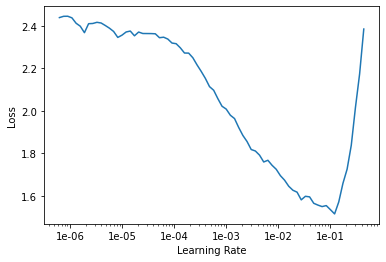

In [365]:
learner.lr_find()
learner.recorder.plot()

As expected we get a very similar plot as before.

Go through our best parameters and see if we get improved results.

In [376]:
lr = (2e-2)/2

In [377]:
learner.fit_one_cycle(8, lr, moms=(0.8, 0.7), wd=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.979796,1.576314,0.728022,0.271978,00:39
1,0.789235,2.161997,0.417582,0.582418,00:38
2,0.662587,0.515391,0.859890,0.140110,00:39
3,0.558325,0.442891,0.876374,0.123626,00:39
4,0.465942,0.231380,0.939560,0.060440,00:38
5,0.371222,0.207462,0.934066,0.065934,00:39
6,0.309352,0.182545,0.945055,0.054945,00:39
7,0.272037,0.170048,0.939560,0.060440,00:39


In [378]:
learner.save('first')

That's far from our best, but good nonetheless. Let's unfreeze to the second layer. Our validation loss is more than our training loss, so we can still perform some training without overfitting.

In [394]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])
learner.load('first');

In [395]:
learner.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


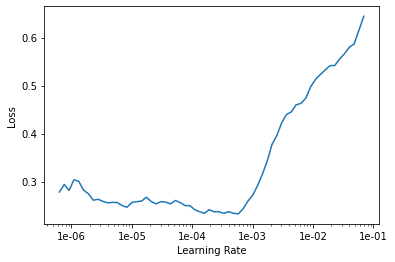

In [384]:
learner.lr_find()
learner.recorder.plot();

In [396]:
learner.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.291081,0.260282,0.923077,0.076923,00:51


In [397]:
learner.save('second')

In [398]:
learner.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


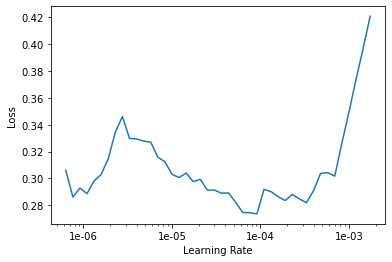

In [399]:
learner.lr_find()
learner.recorder.plot();

In [400]:
learner.fit_one_cycle(1, 5e-5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.283706,0.204962,0.934066,0.065934,00:53


In [401]:
learner.save('third')

In [402]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


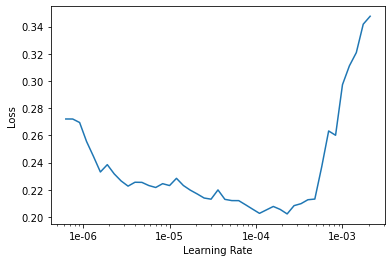

In [403]:
learner.lr_find()
learner.recorder.plot()

In [404]:
learner.fit_one_cycle(3, slice(2e-5, 2e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.226840,0.213098,0.942308,0.057692,00:51
1,0.273444,0.203417,0.950549,0.049451,00:53
2,0.251466,0.161104,0.953297,0.046703,00:53


In [406]:
learner.fit_one_cycle(1, slice(2e-5, 2e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.222595,0.172254,0.958791,0.041209,00:53


In [407]:
learner.save('resnet152-tfms-unfrozen')

That's a pretty good result (0.041209).

In [421]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])

In [422]:
lr = 2e-2/2

In [423]:
learner.fit_one_cycle(6, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.048660,1.582624,0.678571,0.321429,00:46
1,0.854030,0.682082,0.835165,0.164835,00:47
2,0.687261,0.420635,0.895604,0.104396,00:46
3,0.563484,0.272304,0.920330,0.079670,00:47
4,0.430940,0.208707,0.939560,0.060440,00:47
5,0.335256,0.192344,0.942308,0.057692,00:47


In [424]:
learner.save('first')

In [447]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])
learner.load('first');

In [448]:
learner.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


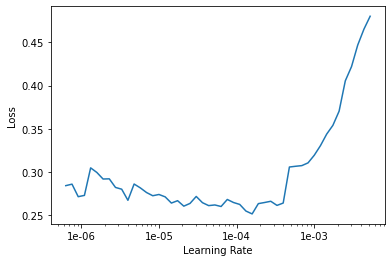

In [432]:
learner.lr_find()
learner.recorder.plot()

In [449]:
learner.fit_one_cycle(1, slice(4e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.346400,0.233663,0.931319,0.068681,00:51


In [435]:
learner.save('second')

In [438]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])
learner.load('second');

In [450]:
learner.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


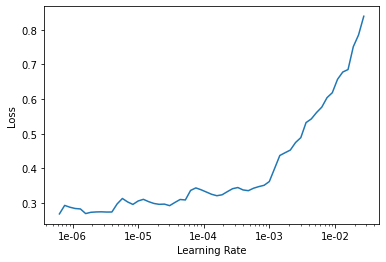

In [451]:
learner.lr_find()
learner.recorder.plot()

In [453]:
learner.fit_one_cycle(1, slice(4e-6), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.289564,0.216803,0.931319,0.068681,00:54


In [443]:
learner.save('third')

In [454]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


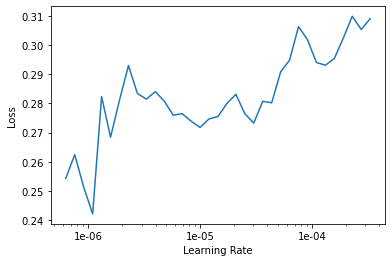

In [455]:
learner.lr_find()
learner.recorder.plot()

In [456]:
learner.fit_one_cycle(3, slice(3e-6, 2e-5), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.256800,0.200598,0.934066,0.065934,00:54
1,0.282173,0.193948,0.942308,0.057692,00:53
2,0.261942,0.200244,0.939560,0.060440,00:54


Nothing good comes out of this model.

# Submission

In [504]:
train = (ImageList.from_df(data, data_root/"images", suffix=".jpg")
       .split_by_rand_pct(0.2, seed=2)
       .label_from_df("class")
       .add_test(test_data)
       .transform(get_transforms(), size=224)
       .databunch(bs=32)
       .normalize(imagenet_stats))

In [505]:
learner = cnn_learner(train, models.resnet152, metrics=[accuracy, error_rate])

Not unfrozen models:

In [485]:
learner.load('resnet152-best')
name="unfrozen1.csv"

In [493]:
learner.load('resnet152-best3');
name="unfrozen2.csv"

Frozen models:

In [497]:
learner.load('resnet152-best-unfrozen');
name="unfrozen.csv"

In [502]:
learner.load('resnet152-best-frozen2');
name="unfrozen3.csv"

With transformers:

In [506]:
learner.load('resnet152-tfms-unfrozen');
name="tfms.csv"

In [507]:
preds, y = learner.get_preds(DatasetType.Test)

subm = pd.read_csv(data_root/"sample_submission.csv")
subm[healthy] = preds[:, 0]
subm[mult] = preds[:, 1]
subm[rust] = preds[:, 2]
subm[scab] = preds[:, 3]
subm.to_csv(name, index=False)